# Real or Not? NLP with Disaster Tweets - LR, SVM, RF, GBM

[Predict which Tweets are about real disasters and which ones are not](https://www.kaggle.com/c/nlp-getting-started)

_Y. Sun_

In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/ys/github/kaggle/')

from mypreprocessor import unslang

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
df_train = pd.read_csv('train.csv')
df_train.tail(3)

,id,keyword,location,text,target
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


## Text preprocessing

### Characters cleaning

In [20]:
import os
import re
import string

def remove_url(text):
    """Remove URL in the text."""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    """Remove HTML tags in the text."""
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    """Remove punctuations in text."""
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    table = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(table)

In [21]:
df_train['text'] = df_train['text'].apply(remove_url)
df_train['text'] = df_train['text'].apply(remove_html)
df_train['text'] = df_train['text'].apply(remove_emoji)
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_train.tail(3)

,id,keyword,location,text,target
7610,10871,NaN,NaN,M194 0104 UTC5km S of Volcano Hawaii,1
7611,10872,NaN,NaN,Police investigating after an ebike collided w...,1
7612,10873,NaN,NaN,The Latest More Homes Razed by Northern Califo...,1


### Words cleaning (normalization)

In [22]:
from spellchecker import SpellChecker
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

def spelling(text):
    """Correct spelling mistakes in the text."""
    corrected_text = []
    spell = SpellChecker()
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

def stemming(text):    
    """Stem each word based on word root in the given text."""
    SBStemmer = SnowballStemmer('english')
    text = [SBStemmer.stem(word) for word in text.split()]
    return " ".join(text)

def lemmatizing(text):
    pass

def remove_stopwords(text):
    """Remove stopwards in text."""
    sw = stopwords.words('english')
    # remove the stop words and lowercase the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [23]:
#df_train['text'] = df_train['text'].apply(spelling)
df_train['text'] = df_train['text'].apply(stemming)
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_train['text'] = df_train['text'].apply(unslang)
df_train.tail(3)

,id,keyword,location,text,target
7610,10871,NaN,NaN,m194 0104 utc5km volcano hawaii,1
7611,10872,NaN,NaN,polic investig ebik collid car littl portug eb...,1
7612,10873,NaN,NaN,latest home raze northern california wildfir a...,1


#### _* compare stemming and lemmatizing_

In [34]:
import spacy # !python -m spacy download en_core_web_sm
import nltk

# load spacy's English language models
en_nlp = spacy.load('en_core_web_sm')
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print('Lemmatization:')
    print([token.lemma_ for token in doc_spacy if token.lemma_ != '-PRON-'])
    # print tokens found by Porter stemmer
    print('Stemming')
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

compare_normalization("Our meeting was worse than yesterday, "
                       "I'm scared of meeting the clients.")

Lemmatization:
['meeting', 'be', 'bad', 'than', 'yesterday', ',', 'be', 'scared', 'of', 'meet', 'the', 'client', '.']
Stemming
['our', 'meet', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', '.']


#### _* bag-of-words_

- Tokenization
- Vocabulary building
- Encoding (one-hot)
- n-Grams

#### _* CountVectorizer wth lemmatization_

In [ ]:
# regexp used in CountVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old (default) tokenizer
nlp = spacy.load('en_core_web_sm')
old_tokenizer = nlp.tokenizer
# replace the tokenizer with the preceding regexp
# nlp <-- old_tokenizer.tokens_from_list (new in v2.0)
nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline
# (now using our own tokennizer)
def custom_tokenizer(document):
    doc_spacy = nlp(document, disable=["tagger", "parser"])
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

# transform X_train_text using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(X_train_text)
print('X_train_lemma.shape: {}'.format(X_train_lemma.shape))

## Machine learning model

The advantages of building pipelines:

- Reduce the preprocessing and classification process;
- Avoid information leakage from validation datasets during cross-validation (cross_val_score or GridSearchCV).

In [24]:
import mglearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.pipeline import make_pipeline

In [25]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    df_train['text'], df_train['target'], test_size=0.2, random_state=42) 

### Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(CountVectorizer(min_df=5), LogisticRegression(max_iter=500))
scores = cross_val_score(pipe, X_train_text, y_train, scoring='f1')
print('Cross-validation of f1-score:', scores)
print('Mean cross-validation f1-score: {:.2f}'.format(np.mean(scores)))

Cross-validation of f1-score: [0.72783505 0.72871287 0.74823054 0.71576763 0.74170854]
Mean cross-validation f1-score: 0.73


In [ ]:
param_grid = {'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=-1)
grid.fit(X_train_text, y_train)

print('Best cross-validation f1-score: {:.2f}'.format(grid.best_score_))
print('F1-score of validation data: {:.2f}'.format(grid.score(X_val_text, y_val)))
print('Confusion matrix:\n', confusion_matrix(y_val, grid.predict(X_val_text)))
print(classification_report(y_val, grid.predict(X_val_text), labels=grid.best_estimator_.classes_))

Number of features: 2073
First 100 features:
['05' '06' '10' '100' '1000' '101' '11' '11yearold' '12' '12000' '13' '14'
 '15' '16' '16yr' '17' '18' '19' '1945' '1980' '1st' '20' '2011' '2013'
 '2014' '2015' '21' '22' '24' '25' '26' '2nd' '30' '300' '300w' '31' '320'
 '33' '3g' '40' '4000' '4wd' '4x4' '50' '500' '53inch' '5km' '60' '600'
 '70' '70th' '90' '911' 'aba' 'abandon' 'abc' 'abl' 'ablaz' 'absolut'
 'abstorm' 'abus' 'access' 'accid' 'accord' 'account' 'accus' 'acr'
 'across' 'act' 'action' 'activ' 'actual' 'ad' 'add' 'admit' 'adult'
 'advanc' 'advisori' 'af' 'affect' 'afghan' 'afghanistan' 'africa'
 'afternoon' 'aftershock' 'age' 'ago' 'agre' 'ah' 'ahead' 'aid' 'aim'
 'aint' 'air' 'aircraft' 'airlin' 'airplan' 'airport' 'aka' 'alabama']
Every 100 features:
['05' 'alarm' 'bank' 'brown' 'cold' 'decid' 'econom' 'feat' 'glass' 'host'
 'kerricktri' 'lower' 'mood' 'organ' 'prepared' 'repatri' 'senat' 'spend'
 'temper' 'tv' 'whole']
Weighs of the most important features:


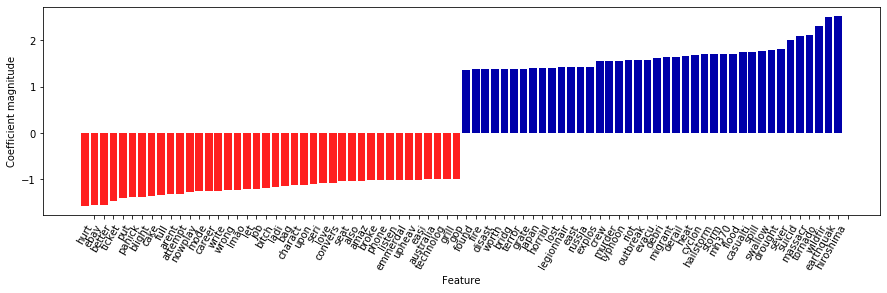

In [69]:
vect = grid.best_estimator_.named_steps['countvectorizer']
feature_names = np.array(vect.get_feature_names())

print('Number of features: {}'.format(len(feature_names)))
print('First 100 features:\n{}'.format(feature_names[:100]))
print('Every 100 features:\n{}'.format(feature_names[::100]))

print('Weighs of the most important features:')
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
bottom, top = plt.ylim()

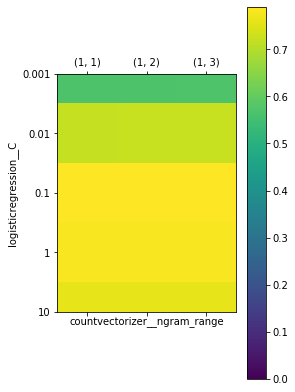

Best parameters:  {'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 0.1}
Best estimator:  Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=5,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [160]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, 5).T, 
            vmin=0, cmap='viridis') 
plt.xlabel('countvectorizer__ngram_range')
plt.ylabel('logisticregression__C')
plt.xticks(range(len(param_grid['countvectorizer__ngram_range'])), 
           param_grid['countvectorizer__ngram_range'])
plt.yticks(range(len(param_grid['logisticregression__C'])), 
           param_grid['logisticregression__C'])
plt.colorbar()
plt.show()

print('Best parameters: ', grid.best_params_)
print('Best estimator: ', grid.best_estimator_)

Number of features: 2827
First 100 features:
['05' '06' '10' '100' '1000' '101' '11' '11yearold' '11yearold boy' '12'
 '12000' '12000 nigerian' '13' '14' '15' '15 saudi' '16' '16yr' '16yr old'
 '17' '18' '19' '1945' '1980' '1980 prebreak' '1st' '20' '2011' '2013'
 '2014' '2015' '2015 australia' '2015 prebreak' '21' '22' '24' '25' '26'
 '2nd' '30' '30 fire' '300' '300w' '300w curv' '31' '320' '320 ir' '33'
 '33 hollywood' '3g' '3g whole' '40' '40 famili' '4000' '4000 syrian'
 '4wd' '4x4' '4x4 offroad' '50' '500' '53inch' '53inch 300w' '5km'
 '5km volcano' '60' '600' '70' '70 year' '70th' '70th anniversari' '90'
 '911' 'aba' 'aba woman' 'abandon' 'abandon aircraft' 'abc' 'abc news'
 'abl' 'ablaz' 'absolut' 'abstorm' 'abus' 'access' 'accid' 'accid expert'
 'accid man' 'accord' 'account' 'accus' 'acr' 'across' 'act' 'action'
 'action year' 'activ' 'actual' 'ad' 'ad video' 'add']
Every 100 features:
['05' 'admit' 'appear' 'bedroom' 'broke' 'chicagoarea gay' 'countri'
 'derail villag' 'earth

(-0.7137676452420358, 1.1595421450179533)

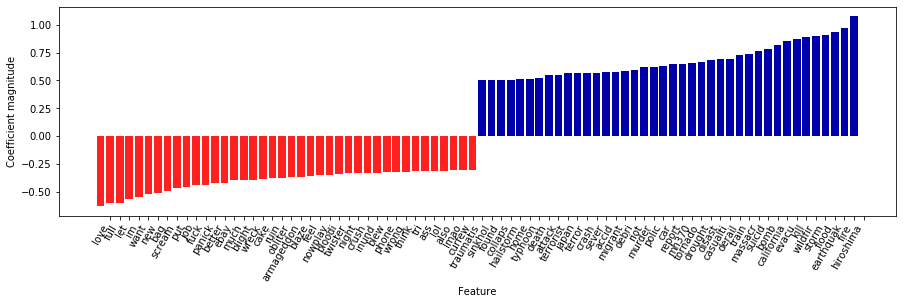

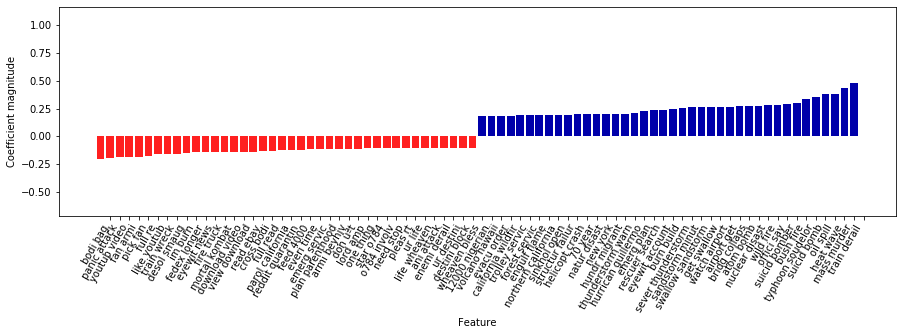

In [163]:
vect = grid.best_estimator_.named_steps['countvectorizer']
feature_names = np.array(vect.get_feature_names())

print('Number of features: {}'.format(len(feature_names)))
print('First 100 features:\n{}'.format(feature_names[:100]))
print('Every 100 features:\n{}'.format(feature_names[::100]))

# weights of features
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
bottom, top = plt.ylim()

# find 2-gram feaures
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 2
# visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask], 
                                     feature_names[mask], n_top_features=40)
plt.ylim(bottom, top)

In [77]:
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

df_sub['target'] = grid.predict(df_test['text'])
df_sub.to_csv('submission.csv', index=False)
df_sub.tail(3)

,id,target
3260,10868,0
3261,10874,0
3262,10875,0


### SVM

In [119]:
from sklearn.svm import SVC
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 1), min_df=5, norm=None), SVC())
scores = cross_val_score(pipe, X_train_text, y_train, scoring='f1')
print('Cross-validation of scores:', scores)
print('Mean of cross-validation scores: {:.2f}'.format(np.mean(scores)))

Cross-validation of f1-score: [0.72586016 0.75211864 0.74840085 0.70358306 0.74364407]
Mean cross-validation f1-score: 0.73


In [139]:
param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'svc__gamma': ['scale', 'auto']}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', n_jobs=-1)
grid.fit(X_train_text, y_train)

print('Best cross-validation f1-score: {:.2f}'.format(grid.best_score_))
print('F1-score of validation data: {:.2f}'.format(grid.score(X_val_text, y_val)))
print('Confusion matrix:\n', confusion_matrix(y_val, grid.predict(X_val_text)))

Best cross-validation f1-score: 0.80
F1-score of validation data: 0.80
Confusion matrix:
 [[784  90]
 [212 437]]


In [153]:
# get vectorizer in a grid-searched pipeline
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
# get feature names
feature_names = np.array(vect.get_feature_names())

print('Number of features: {}'.format(len(feature_names)))
print('First 50 features:\n{}'.format(feature_names[:50]))
print('Every 100 features:\n{}'.format(feature_names[::100]))

# transform the training datsets
X_train = vect.transform(X_train_text)
# find maximm value for each of the features over the datasets
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print('Features with lowest tfidf:\n{}'.format(
    feature_names[sorted_by_tfidf[:20]]))
print('Features with highest tfidf:\n{}'.format(
    feature_names[sorted_by_tfidf[-20:]]))

sorted_by_idf = np.argsort(vect.idf_)
print('Features with lowest idf (less important):\n{}'.format(
    feature_names[sorted_by_idf[:100]]))

Number of features: 2073
First 50 features:
['05' '06' '10' '100' '1000' '101' '11' '11yearold' '12' '12000' '13' '14'
 '15' '16' '16yr' '17' '18' '19' '1945' '1980' '1st' '20' '2011' '2013'
 '2014' '2015' '21' '22' '24' '25' '26' '2nd' '30' '300' '300w' '31' '320'
 '33' '3g' '40' '4000' '4wd' '4x4' '50' '500' '53inch' '5km' '60' '600'
 '70']
Every 100 features:
['05' 'alarm' 'bank' 'brown' 'cold' 'decid' 'econom' 'feat' 'glass' 'host'
 'kerricktri' 'lower' 'mood' 'organ' 'prepared' 'repatri' 'senat' 'spend'
 'temper' 'tv' 'whole']
Features with lowest tfidf:
['come' 'scream' 'death' 'drown' 'deton' 'hijack' 'full' 'last' 'mani'
 'weapon' 'wave' 'die' 'flame' 'collid' 'anoth' 'catastroph' 'hot' 'photo'
 'northern' 'right']
Features with highest tfidf:
['insur' 'yeah' 'beach' 'pain' 'gt' 'pray' 'bag' 'test' 'court' 'fuck'
 'hill' 'navi' 'gtgt' 'ar' 'shoe' 'issu' 'check' 'bus' 'bestnaijamad'
 'wreck']
Features with lowest idf (less important):
['like' 'fire' 'get' 'im' 'amp' 'bomb' 'via'

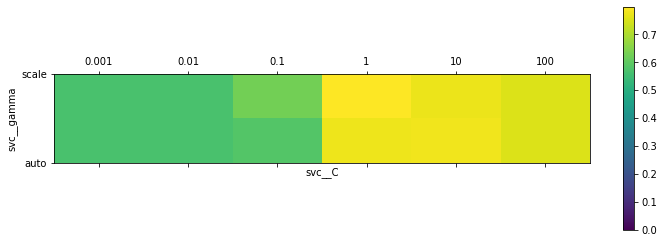

Best paramters: {'svc__C': 1, 'svc__gamma': 'scale'}


In [154]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(6, 2).T,
            vmin=0, cmap='viridis') 
plt.xlabel('svc__C')
plt.ylabel('svc__gamma')
plt.xticks(range(len(param_grid['svc__C'])), 
           param_grid['svc__C'])
plt.yticks(range(len(param_grid['svc__gamma'])), 
           param_grid['svc__gamma'])
plt.colorbar()
plt.show()

print('Best paramters:', grid.best_params_)

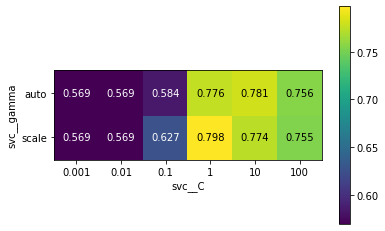

Best parameters:  {'svc__C': 1, 'svc__gamma': 'scale'}
Best estimator:  Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class

In [151]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(6, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel='svc__C', ylabel='svc__gamma', cmap='viridis', fmt='%.3f', 
    xticklabels=param_grid['svc__C'], 
    yticklabels=param_grid['svc__gamma'])
plt.colorbar(heatmap)
plt.show()

print('Best parameters: ', grid.best_params_)
print('Best estimator: ', grid.best_estimator_)

In [155]:
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

df_sub['target'] = grid.predict(df_test['text'])
df_sub.to_csv('submission.csv', index=False)
df_sub.tail(3)

,id,target
3260,10868,0
3261,10874,0
3262,10875,0


### Random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), 
                     RandomForestClassifier(random_state=42))
scores = cross_val_score(pipe, X_train_text, y_train, scoring='f1')
print('Cross-validation of scores:', scores)
print('Mean of cross-validation scores: {:.2f}'.format(np.mean(scores)))

Cross-validation of scores: [0.7159309  0.73345936 0.7322298  0.70658683 0.73875598]
Mean of cross-validation scores: 0.73


In [29]:
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)], 
              'randomforestclassifier__max_features': [1, 2, 3]}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', n_jobs=-1)
grid.fit(X_train_text, y_train)

print('Best cross-validation f1-score: {:.2f}'.format(grid.best_score_))
print('F1-score of validation data: {:.2f}'.format(grid.score(X_val_text, y_val)))
print('Confusion matrix:\n', confusion_matrix(y_val, grid.predict(X_val_text)))

Best cross-validation f1-score: 0.52
F1-score of validation data: 0.91
Confusion matrix:
 [[853  21]
 [ 93 556]]


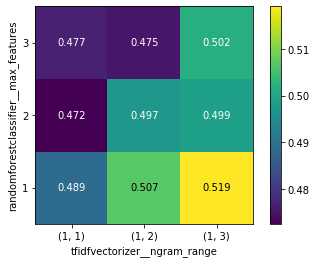

Best parameters:  {'randomforestclassifier__max_features': 3, 'tfidfvectorizer__ngram_range': (1, 1)}
Best estimator:  Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 1), norm=None,
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                   

In [34]:
scores = grid.cv_results_['mean_test_score'].reshape(3, 3).T
heatmap = mglearn.tools.heatmap(scores, 
                                xlabel='tfidfvectorizer__ngram_range', 
                                ylabel='randomforestclassifier__max_features', cmap='viridis', fmt='%.3f', 
                                xticklabels=param_grid['tfidfvectorizer__ngram_range'], 
                                yticklabels=param_grid['randomforestclassifier__max_features'])
plt.colorbar(heatmap)
plt.show()

print('Best parameters: ', grid.best_params_)
print('Best estimator: ', grid.best_estimator_)

In [35]:
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

df_sub['target'] = grid.predict(df_test['text'])
df_sub.to_csv('submission.csv', index=False)
df_sub.tail(3)

,id,target
3260,10868,1
3261,10874,1
3262,10875,0


### GBM

The present implementations of gradient boosting algrithm include AdaBoost, XGBoost, LightGBM and CatBoost. Here, Xgboost is tested.

In [ ]:
# params = {
#     'max_depth': list(range(5, 11)),
#     'learning_rate': list(np.arange(0.05, 0.30, 0.05)),
#     'gamma': list(np.arange(0.01, 0.06, 0.01)),
#     'min_child_weight': list(range(1, 6)),
    
#     # fixed params
#     'n_estimators' : [1500],
#     'n_jobs': [4],
#     'objective': ['binary:logistic'],
#     'eval_metric' : ['logloss'],
#     'random_state': [42]
# }

# model = XGBClassifier(tree_method='gpu_hist')
# cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

# cv.fit(X_train, y_train)

In [26]:
from xgboost import XGBClassifier, plot_importance

vect = TfidfVectorizer(min_df=5)
X_train = vect.fit_transform(X_train_text)
X_val = vect.transform(X_val_text)

model = XGBClassifier(n_estimators=200, 
                      learning_rate=0.2, 
                      max_depth=6, 
                      min_child_weight=2, 
                      colsample_bytree=0.7, 
                      subsample=0.75, 
                      objective='binary:logistic', 
                      eval_metric=["auc", "logloss", "error"], 
                      early_stopping_rounds=20)

eval_set=[(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, early_stopping_rounds=20, 
          eval_metric=['auc', 'error', 'logloss'], eval_set=eval_set, verbose=True)

y_val_pred = model.predict(X_val)
print('Accuracy: %.2f %%' % (accuracy_score(y_val, y_val_pred) * 100))
print('F1-score: {:.2f}'.format(f1_score(y_val, y_val_pred)))
print('Confusion matrix: \n', confusion_matrix(y_val, y_val_pred))

[0]	validation_0-auc:0.599699	validation_0-error:0.351067	validation_0-logloss:0.672934	validation_1-auc:0.593408	validation_1-error:0.350624	validation_1-logloss:0.673772
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 20 rounds.
[1]	validation_0-auc:0.618836	validation_0-error:0.334811	validation_0-logloss:0.658466	validation_1-auc:0.619341	validation_1-error:0.336179	validation_1-logloss:0.659227
[2]	validation_0-auc:0.645219	validation_0-error:0.315435	validation_0-logloss:0.647159	validation_1-auc:0.643984	validation_1-error:0.32042	validation_1-logloss:0.648164
[3]	validation_0-auc:0.658008	validation_0-error:0.307718	validation_0-logloss:0.638007	validation_1-auc:0.652653	validation_1-error:0.313198	validation_1-logloss:0.639945
[4]	validation_0-auc:0.688226	validation_0-error:0.301149	validation_0-logloss:0.629971	validation_1-auc:0.676024	validation_1-error:0.308601	valida

[47]	validation_0-auc:0.86792	validation_0-error:0.206076	validation_0-logloss:0.492049	validation_1-auc:0.816785	validation_1-error:0.242285	validation_1-logloss:0.527783
[48]	validation_0-auc:0.869758	validation_0-error:0.204105	validation_0-logloss:0.490224	validation_1-auc:0.817527	validation_1-error:0.240972	validation_1-logloss:0.527379
[49]	validation_0-auc:0.870657	validation_0-error:0.201806	validation_0-logloss:0.488468	validation_1-auc:0.815657	validation_1-error:0.244911	validation_1-logloss:0.527666
[50]	validation_0-auc:0.871535	validation_0-error:0.199507	validation_0-logloss:0.486819	validation_1-auc:0.815276	validation_1-error:0.241628	validation_1-logloss:0.526768
[51]	validation_0-auc:0.872185	validation_0-error:0.197537	validation_0-logloss:0.485243	validation_1-auc:0.814689	validation_1-error:0.240972	validation_1-logloss:0.526322
[52]	validation_0-auc:0.872566	validation_0-error:0.197865	validation_0-logloss:0.483626	validation_1-auc:0.815786	validation_1-error:0.

[95]	validation_0-auc:0.901648	validation_0-error:0.171264	validation_0-logloss:0.429817	validation_1-auc:0.825493	validation_1-error:0.229153	validation_1-logloss:0.500795
[96]	validation_0-auc:0.901627	validation_0-error:0.170772	validation_0-logloss:0.428899	validation_1-auc:0.825848	validation_1-error:0.22981	validation_1-logloss:0.500186
[97]	validation_0-auc:0.902161	validation_0-error:0.170772	validation_0-logloss:0.428009	validation_1-auc:0.825382	validation_1-error:0.231779	validation_1-logloss:0.500584
[98]	validation_0-auc:0.902954	validation_0-error:0.170936	validation_0-logloss:0.427101	validation_1-auc:0.825456	validation_1-error:0.232436	validation_1-logloss:0.500124
[99]	validation_0-auc:0.90319	validation_0-error:0.170936	validation_0-logloss:0.426092	validation_1-auc:0.825463	validation_1-error:0.231779	validation_1-logloss:0.499293
[100]	validation_0-auc:0.903937	validation_0-error:0.169951	validation_0-logloss:0.425019	validation_1-auc:0.826318	validation_1-error:0.

[143]	validation_0-auc:0.918297	validation_0-error:0.155008	validation_0-logloss:0.392409	validation_1-auc:0.83284	validation_1-error:0.222587	validation_1-logloss:0.486466
[144]	validation_0-auc:0.918574	validation_0-error:0.154516	validation_0-logloss:0.391771	validation_1-auc:0.832421	validation_1-error:0.222587	validation_1-logloss:0.486796
[145]	validation_0-auc:0.918512	validation_0-error:0.154187	validation_0-logloss:0.391132	validation_1-auc:0.831709	validation_1-error:0.225213	validation_1-logloss:0.487766
[146]	validation_0-auc:0.918753	validation_0-error:0.154187	validation_0-logloss:0.390521	validation_1-auc:0.832057	validation_1-error:0.225213	validation_1-logloss:0.487429
[147]	validation_0-auc:0.918748	validation_0-error:0.154516	validation_0-logloss:0.390012	validation_1-auc:0.832253	validation_1-error:0.2239	validation_1-logloss:0.487559
[148]	validation_0-auc:0.918957	validation_0-error:0.155172	validation_0-logloss:0.389347	validation_1-auc:0.832125	validation_1-erro

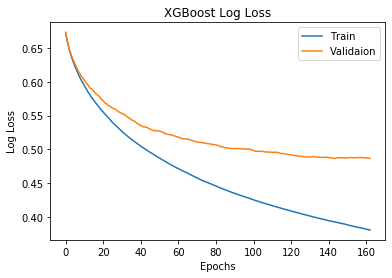

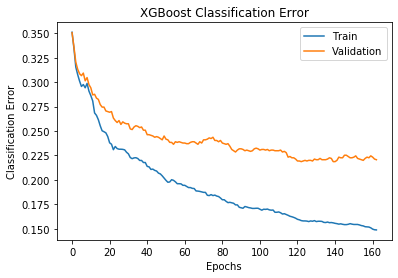

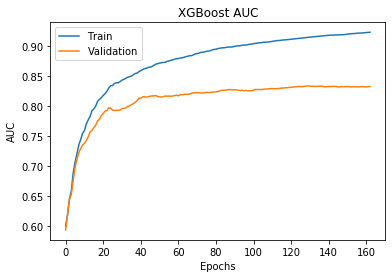

In [27]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Validaion')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()
# plot auc
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

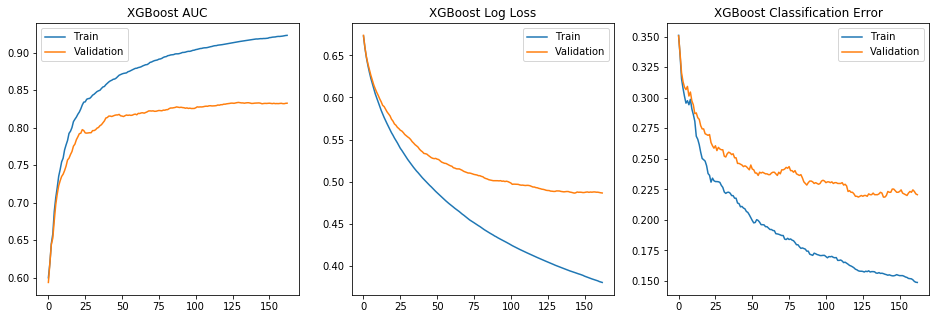

In [31]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))

# plot auc
ax1.plot(x_axis, results['validation_0']['auc'], label='Train')
ax1.plot(x_axis, results['validation_1']['auc'], label='Validation')
ax1.set_title("XGBoost AUC")
ax1.legend()

# plot log loss
ax2.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax2.plot(x_axis, results['validation_1']['logloss'], label='Validation')
ax2.set_title("XGBoost Log Loss")
ax2.legend()

# plot classification error
ax3.plot(x_axis, results['validation_0']['error'], label='Train')
ax3.plot(x_axis, results['validation_1']['error'], label='Validation')
ax3.set_title("XGBoost Classification Error")
ax3.legend()

plt.show()

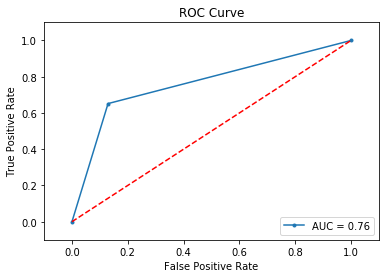

In [32]:
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
auc_score = auc(fpr, tpr)

plt.figure()
plt.title('ROC Curve')
plt.plot(fpr, tpr, marker='.', label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [34]:
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')

X_test = vect.transform(df_test['text'])
df_sub['target'] = model.predict(X_test)
df_sub.to_csv('submission.csv', index=False)
df_sub.tail(3)

,id,target
3260,10868,0
3261,10874,0
3262,10875,0


In [35]:
# submit
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "xgboost"

100%|██████████████████████████████████████| 22.2k/22.2k [00:03<00:00, 6.12kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

In [40]:
# score on LB
!kaggle competitions submissions -c nlp-getting-started

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2020-04-09 18:22:16  xgboost               complete  0.68916      None          
submission.csv  2020-04-06 18:53:51  ys02                  complete  0.67280      None          
submission.csv  2020-04-06 17:46:16  ys01                  complete  0.66053      None          
submission.csv  2020-04-05 13:20:07  ys01                  complete  0.71267      None          
submission.csv  2020-04-04 22:23:58  ys01                  complete  0.71472      None          
submission.csv  2020-04-04 08:59:33  ys02                  complete  0.70347      None          
submission.csv  2020-04-04 06:18:21  ys01                  complete  0.70347      None          
submission.csv  2020-03-31 22:57:29  ys02                  complete  0.78220      None          
submission.csv  2020-03-31 22: